In [3]:
# imports from custom library
import sys
sys.path.append('../../')
import matplotlib.pyplot as plt
from mlrefined_libraries import superlearn_library as superlearn
import autograd.numpy as np
import pandas as pd
%matplotlib notebook

# this is needed to compensate for %matplotlib notebook's tendancy to blow up images when plotted inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Linear Supervised Learning Series

# Part 4: Support vector machines

Here we discuss an often used variation of the original perceptron, called the margin perceptron. We then build on this fundamental concept to derive *support vector machines*, a popular method used for linear classification. 

Press the button 'Toggle code' below to toggle code on and off for entire this presentation.

In [2]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

# 1.  Support vector machines

In this Section we derive support vector machines based on the notion of a *margin-perceptron*.

## 1.1 The margin-perceptron

Suppose:

- a two-class dataset $\left\{ \left(\mathbf{x}_{p},y_{p}\right)\right\} _{p=1}^{P}$ with the labels $y_p \in \{-1,+1\}$  

- our dataset is perfectly linearly separable with a known linear decision boundary $w_0+\mathbf{x}^{T}\mathbf{w}^{\,}=0$ passing evenly between the two classes

<p><img src= '../../mlrefined_images/superlearn_images/Fig_4_4_new.png' width="60%" height="auto"/></p>

Note: the translations are more generally defined as $w_0+\mathbf{x}^{T}\mathbf{w}^{\,}=+\beta^{\,}$ and $w_0+\mathbf{x}^{T}\mathbf{w}^{\,}=-\beta^{\,}$. But we can divide off $\beta$ in both equations and reassign the variables as $w_0\longleftarrow\frac{w_0}{\beta}$ and $\mathbf{w}\longleftarrow\frac{\mathbf{w}}{\beta}$ to get $w_0+\mathbf{x}^{T}\mathbf{w}^{\,}=\pm1$. 

<p><img src= '../../mlrefined_images/superlearn_images/Fig_4_4_new.png' width="60%" height="auto"/></p>

For all points we have

\begin{equation}
\begin{array}{cc}
w_0+\mathbf{x}_{p}^{T}\mathbf{w}^{\,}\geq1 & \,\,\,\,\text{if} \,\,\, y_{p}=+1\\
w_0+\mathbf{x}_{p}^{T}\mathbf{w}^{\,}\leq-1 & \,\,\,\,\text{if} \,\,\, y_{p}=-1
\end{array}
\end{equation}

<p><img src= '../../mlrefined_images/superlearn_images/Fig_4_4_new.png' width="60%" height="auto"/></p>

These two conditions can be combined into a single statement 

\begin{equation}
y_{p}^{\,}\left(w_0+\mathbf{x}_{p}^{T}\mathbf{w}^{\,}\right)\geq1
\end{equation}

which can be equivalently written as 

\begin{equation}
\mbox{max}\left(0,\,1-y_{p}^{\,}\left(w_0+\mathbf{x}_{p}^{T}\mathbf{w}^{\,}\right)\right)=0
\end{equation}

Summing up this non-negative term for all $P$ points gives the **margin-perceptron** cost

\begin{equation}
g\left(w_0,\mathbf{w}\right)=\underset{p=1}{\overset{P}{\sum}}\mbox{max}\left(0,\,1-y_{p}^{\,}\left(w_0+\mathbf{x}_{p}^{T}\mathbf{w}^{\,}\right)\right)
\end{equation}

Can you tell the difference between the original perceptron cost 

\begin{equation}
g\left(w_0,\mathbf{w}\right)=\underset{p=1}{\overset{P}{\sum}}\mbox{max}\left(0,\,-y_{p}^{\,}\left(w_0+\mathbf{x}_{p}^{T}\mathbf{w}^{\,}\right)\right)
\end{equation}

and the margin-perceptron cost? 

\begin{equation}
g\left(w_0,\mathbf{w}\right)=\underset{p=1}{\overset{P}{\sum}}\mbox{max}\left(0,\,1-y_{p}^{\,}\left(w_0+\mathbf{x}_{p}^{T}\mathbf{w}^{\,}\right)\right)
\end{equation}

We have just 'added a $1$' to the non-zero input of the max function in each summand, preventing the issue of a trivial zero solution.

### What if the data isn't linearly separable?

The margin-perceptron is still a valid cost function. The only difference is that with such a dataset we can not make the criterion

\begin{equation}
\mbox{max}\left(0,\,1-y_{p}^{\,}\left(w_0+\mathbf{x}_{p}^{T}\mathbf{w}^{\,}\right)\right)=0
\end{equation}

hold for all points.

A violation for the $p^{\textrm{th}}$ point then 
adds the positive value of $1-y_{p}^{\,}\left(w_0+\mathbf{x}_{p}^{T}\mathbf{w}^{\,}\right)$ to the cost function.

#### <span style="color:#a50e3e;">Example 1: </span> Using gradient descent to minimize the margin-perceptron cost

Like the original perceptron the magnitude of the full margin-perceptron cost function's gradient will not necessarily diminish to zero, motivating the use of a diminishing steplength.   

<IPython.core.display.Javascript object>


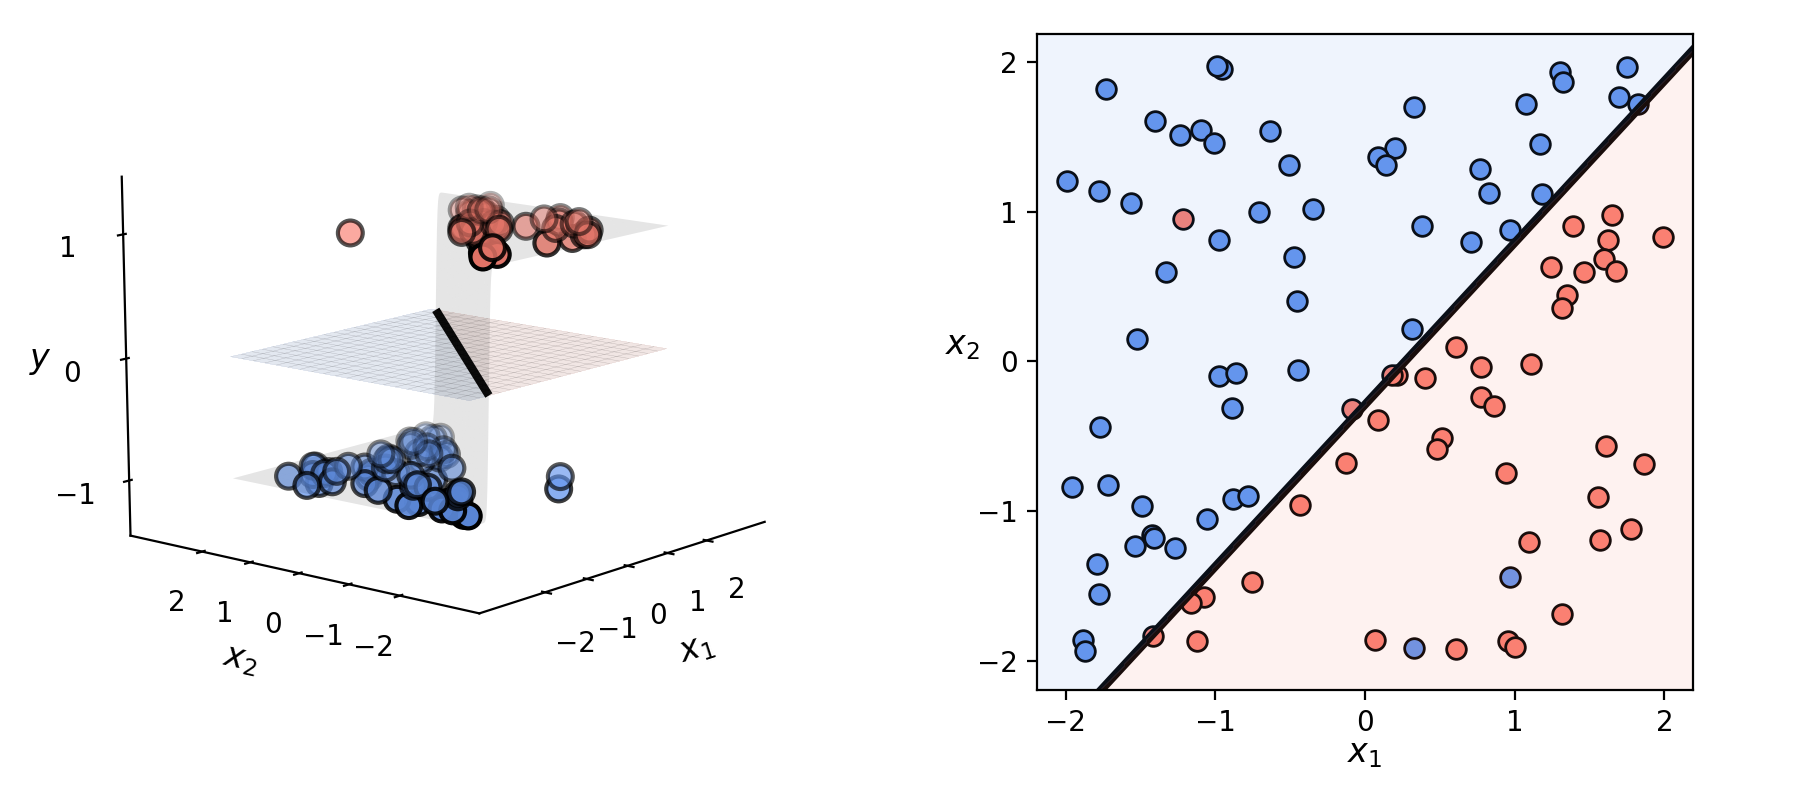

In [6]:
# load in dataset
data = np.loadtxt('../../mlrefined_datasets/superlearn_datasets/3d_classification_data_v0.csv',delimiter = ',')

# define the input and output of our dataset - assuming arbitrary N > 2 here
x = data[:,:-1]
y = data[:,-1]
y.shape = (len(y),1)

# the relu cost function
def margin_perceptron(w):
    cost = 0
    for p in range(0,len(y)):
        x_p = x[p]
        y_p = y[p]
        a_p = w[0] + sum([a*b for a,b in zip(w[1:],x_p)])
        cost += np.maximum(0,1-y_p*a_p)
    return cost

# declare an instance of our current our optimizers
opt = superlearn.optimimzers.MyOptimizers()

# run desired algo with initial point, max number of iterations, etc.,
w_hist = opt.gradient_descent(g = margin_perceptron,w = np.random.randn(np.shape(x)[1]+1,1),max_its = 50,alpha = 10**-2,steplength_rule = 'diminishing')

# create instance of 3d demos
demo5 = superlearn.classification_3d_demos.Visualizer(data)

# draw the final results
demo5.static_fig(w_hist,view = [15,-140])

## 1.2  The smooth softmax approximation to the margin-perceptron cost

As with the perceptron, one way to smooth out the margin-perceptron is by replacing max with softmax. Doing so in one summand gives

\begin{equation}
\text{soft}\left(0,1-y_{p}^{\,}\left(w_0+\mathbf{x}_{p}^{T}\mathbf{w}^{\,}\right)\right) = \text{log}\left( 1 + e^{1-y_{p}^{\,}\left(w_0+\mathbf{x}_{p}^{T}\mathbf{w}^{\,}\right)}\right)
\end{equation}

Right away we can form a smooth cost by summing it up over the entire dataset  

\begin{equation}
g\left(w_0,\mathbf{w}\right)=\underset{p=1}{\overset{P}{\sum}}\text{log}\left( 1 + e^{1-y_{p}^{\,}\left(w_0+\mathbf{x}_{p}^{T}\mathbf{w}^{\,}\right)}\right)
\end{equation}

Note: in the derivation of the margin perceptron the '1' used in the $1-y_{p}^{\,}\left(w_0+\mathbf{x}_{p}^{T}\mathbf{w}^{\,}\right)$ component of the cost could have been any value $\epsilon > 0$, giving the margin-perceptron criterion as 

\begin{equation}
\mbox{max}\left(0,\,\epsilon-y_{p}^{\,}\left(w_0+\mathbf{x}_{p}^{T}\mathbf{w}^{\,}\right)\right)=0
\end{equation}

<p><img src= '../../mlrefined_images/superlearn_images/epsilon_margin.png' width="60%" height="auto"/></p>

The softmax version of one summand of the cost is then

\begin{equation}
\text{soft}\left(0,\epsilon-y_{p}^{\,}\left(w_0+\mathbf{x}_{p}^{T}\mathbf{w}^{\,}\right)\right) = \text{log}\left( 1 + e^{\epsilon-y_{p}^{\,}\left(w_0+\mathbf{x}_{p}^{T}\mathbf{w}^{\,}\right)}\right)
\end{equation}

When $\epsilon$ is quite small we of course have that $\text{log}\left( 1 + e^{\epsilon-y_{p}^{\,}\left(w_0+\mathbf{x}_{p}^{T}\mathbf{w}^{\,}\right)}\right) \approx \text{log}\left( 1 + e^{-y_{p}^{\,}\left(w_0+\mathbf{x}_{p}^{T}\mathbf{w}^{\,}\right)}\right)$, and we can write the full cost as 

\begin{equation}
g\left(w_0,\mathbf{w}\right)=\underset{p=1}{\overset{P}{\sum}}\text{log}\left( 1 + e^{-y_{p}^{\,}\left(w_0+\mathbf{x}_{p}^{T}\mathbf{w}^{\,}\right)}\right)
\end{equation}

This is precisely the logistic regresssion / smoothed perceptron cost!

This is precisely the **logistic regresssion** / **smoothed perceptron** cost!

## 1.3 A quest for the hyperplane with maximum margin

When two classes of data are linearly separable infinitely many hyperplanes could be drawn to separate the data. Is there one that we can say is the 'best'?

<p><img src= '../../mlrefined_images/superlearn_images/Fig_4_13.png' width="35%" height="auto"/></p>

**The one with the largest margin!** 

### Calculating the margin  

<p><img src= '../../mlrefined_images/superlearn_images/margin_question.png' width="60%" height="auto"/></p>

<p><img src= '../../mlrefined_images/superlearn_images/margin_question.png' width="60%" height="auto"/></p>

\begin{equation}
\left(w_0^{\,} + \mathbf{x}_{1}^T\mathbf{w}^{\,}\right) - \left(w_0^{\,} + \mathbf{x}_{2}^T\mathbf{w}^{\,}\right) =\left(\mathbf{x}_{1}^{\,}-\mathbf{x}_{2}^{\,}\right)^{T}\mathbf{w}^{\,}=2
\end{equation}

\begin{equation}
\left(\mathbf{x}_{1}^{\,}-\mathbf{x}_{2}^{\,}\right)^{T}\mathbf{w}^{\,}=\left\Vert \mathbf{x}_{1}-\mathbf{x}_{2} \right\Vert _2 \cdot\left\Vert \mathbf{w}\right\Vert _{2}
\end{equation}


\begin{equation}
\boxed{\left\Vert \mathbf{x}_{1}-\mathbf{x}_{2} \right\Vert _2=\frac{2}{\left\Vert \mathbf{w}\right\Vert _{2}}}
\end{equation}

Finding the separating hyperplane with maximum margin is equivalent to finding the one with the smallest possible normal vector $\mathbf{w}$ 

<p><img src= '../../mlrefined_images/superlearn_images/Fig_4_14_new.png' width="60%" height="auto"/></p>

## 1.4  The hard-margin and soft-margin SVM problems

Combining our desire to minimize $\left\Vert \mathbf{w}\right\Vert _{2}^{2}$ subject to the constraint
that the hyperplane perfectly separates the data, we have the *hard-margin support vector machine* problem

\begin{equation}
\begin{aligned}\underset{w_0,\,\mathbf{w}}{\mbox{minimize}} & \,\,\left\Vert \mathbf{w}\right\Vert _{2}^{2}\\
\mbox{subject to} & \,\,\,\text{max}\left(0,\,1-y_{p}^{\,}\left(w_0+\mathbf{x}_{p}^{T}\mathbf{w}^{\,}\right) \right)=0,\,\,\,\,p=1,...,P
\end{aligned}
\end{equation}

While there are *constrained optimization* algorithms for this problem, we can also solve it by *relaxing* the constraints

\begin{equation}
g\left(w_0,\mathbf{w}\right)=\underset{p=1}{\overset{P}{\sum}}\text{max}\left(0,\,1-y_{p}^{\,}\left(w_0+\mathbf{x}_{p}^{T}\mathbf{w}^{\,}\right) \right) +  \lambda \left \Vert\mathbf{w}\right\Vert _{2}^{2}
\end{equation}

$\lambda$ is a penalty or regularization parameter, set to a small positive value in practice.

This *regularized* form of the margin-perceptron cost function is usually referred to as the *soft-margin support vector machine cost*

\begin{equation}
g\left(w_0,\mathbf{w}\right)=\underset{p=1}{\overset{P}{\sum}}\text{max}\left(0,\,1-y_{p}^{\,}\left(w_0+\mathbf{x}_{p}^{T}\mathbf{w}^{\,}\right) \right) +  \lambda \left \Vert\mathbf{w}\right\Vert _{2}^{2}
\end{equation}

It allows us to apply SVMs to datasets that are not completely linearly separable, since such a case makes the hard-margin formulation of SVMs infeasible.

#### <span style="color:#a50e3e;">Example 2: </span>  Comparing the SVM decision boundary on linearly separable data

<IPython.core.display.Javascript object>


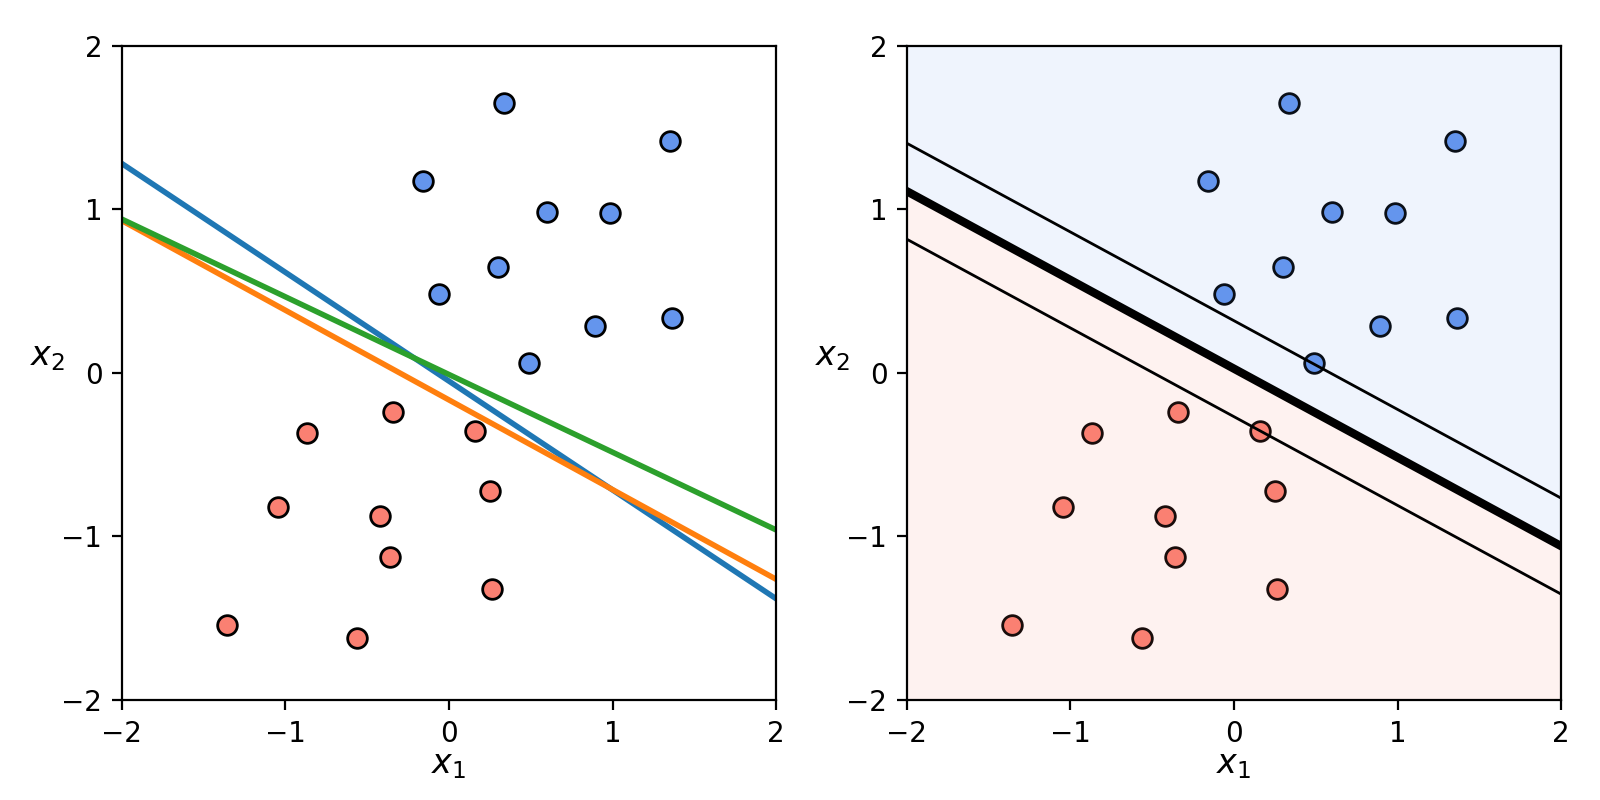

In [10]:
# load in dataset
data = np.loadtxt('../../mlrefined_datasets/superlearn_datasets/svm_demo_data.csv',delimiter = ',')

# define the input and output of our dataset - assuming arbitrary N > 2 here
x = data[:,:-1]
y = data[:,-1]
y.shape = (len(y),1)

# create instance of svm comparision demo
demo5 = superlearn.svm_margin_demo.Visualizer(data)

# run all 
demo5.svm_comparison()         # compute linear decision boundaries
demo5.svm_comparison_fig()     # plot linear decision boundaries

Note how in the right panel the margins pass through points from both classes - equidistant from the SVM linear decision boundary. These points are called *support vectors*, hence the name support vector machine.

## 1.5  Smooth soft-margin SVM and logistic regression

To produce a smoothed version of the soft-margin cost, once again we make use of the softmax approximation, giving a smoothed out soft-margin cost function of the form

\begin{equation}
g\left(\mathbf{w}\right)=\underset{p=1}{\overset{P}{\sum}}\text{log}\left( 1 + e^{-y_{p}\left(w_0+\mathbf{x}_{p}^{T}\mathbf{w}\right)}\right) +  \lambda \left \Vert\mathbf{w}\right\Vert _{2}^{2} 
\end{equation}

This is a *lightly regularized version* of logistic regression. We say lightly because while we set $\lambda$ to quite a small positive value in practice, it is important - at least on datasets that are indeed linearly separable - that $\lambda \neq 0$ exactly.

#### <span style="color:#a50e3e;">Example 3: </span>  Smoothed soft-margin SVM = regularized logistic regression/perceptron 

<IPython.core.display.Javascript object>


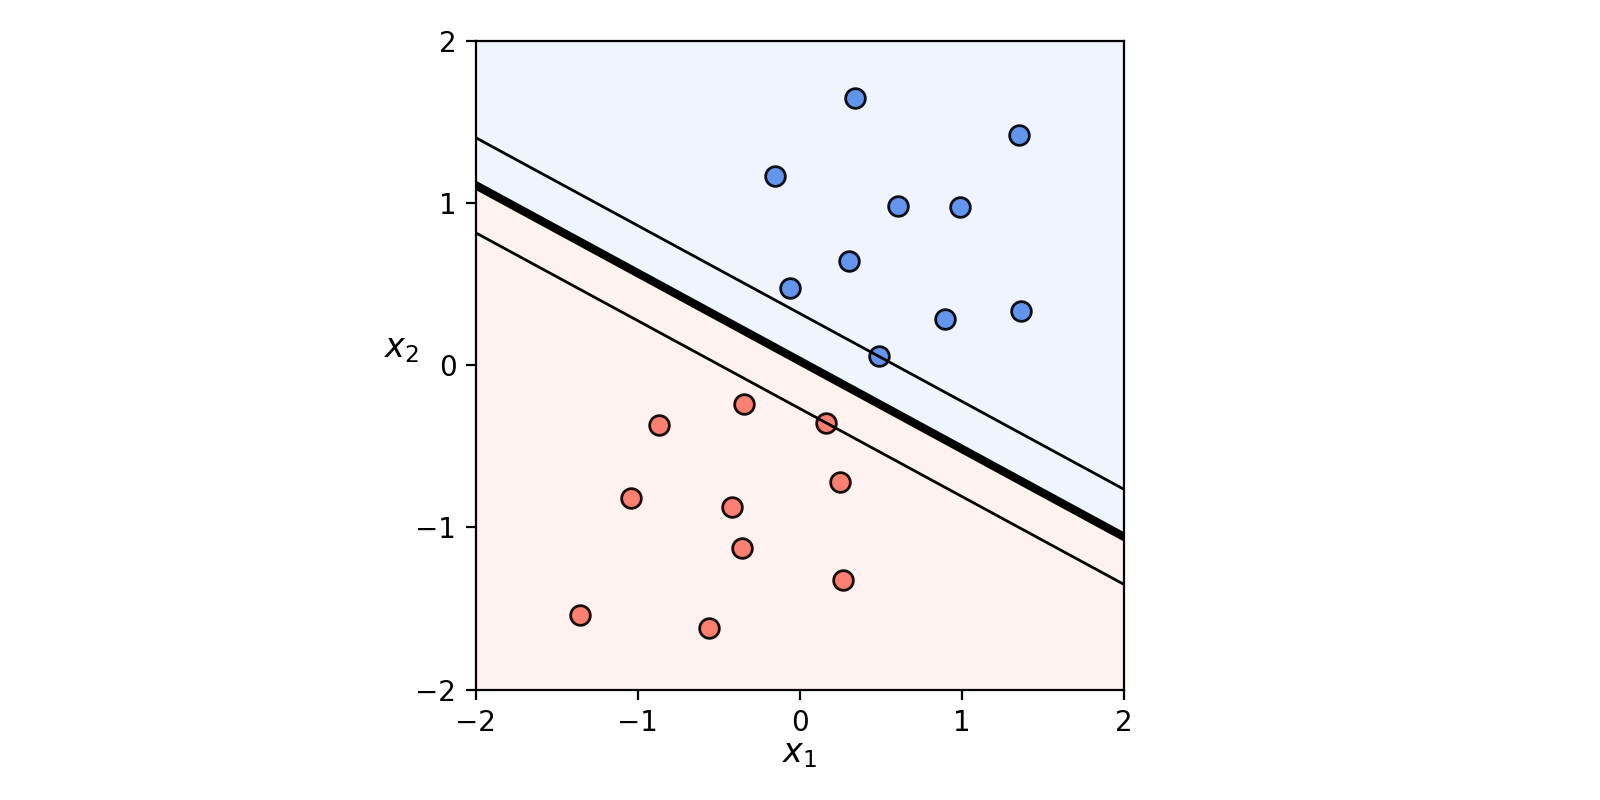

In [12]:
# load in dataset
data = np.loadtxt('../../mlrefined_datasets/superlearn_datasets/svm_demo_data.csv',delimiter = ',')

# define the input and output of our dataset - assuming arbitrary N > 2 here
x = data[:,:-1]
y = data[:,-1]
y.shape = (len(y),1)


# the relu cost function
lam = 10**(-3)
def softmargin_svm(w):
    cost = 0
    for p in range(0,len(y)):
        x_p = x[p]
        y_p = y[p]
        a_p = w[0] + sum([a*b for a,b in zip(w[1:],x_p)])                
        cost += np.log(1 + np.exp(-y_p*a_p))+ lam*np.dot(w[1:].T,w[1:])
    return cost


# declare an instance of our current our optimizers
opt = superlearn.optimimzers.MyOptimizers()

# minimize input cost via Newton's method
w_hist = opt.newtons_method(g = softmargin_svm,w = np.random.randn(np.shape(x)[1]+1,1),max_its = 10,epsilon = 10**-8)


# Create a demonstration instance
demo5 = superlearn.svm_margin_demo.Visualizer(data)

# draw the final results
demo5.softmargin_fig(w_hist)

## 1.6  Linear classification schemes: all are one!

Which approach - logistic regression, the perceptron, or support vector machines - is the best?

- We have seen how all three are intimately related via the softmax cost function

- For a specific dataset one approach may work better than the others, which is why one often runs two or all three approaches in practice.

 - It should come as little surprise that in practice all three approaches tend to perform quite similarly overall (in terms of classification accuracy).